In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Import Datasets

In [2]:
raw_SA_SO_df = pd.read_csv("./../Datasets/kieranFeatures_1-30_14-Nov-2024_rawSA.csv").replace([-np.inf, np.inf], np.nan)
adj_SA_SO_df = pd.read_csv("./../Datasets/kieranFeatures_1-31_24-Jan-2025.csv").replace([-np.inf, np.inf], np.nan)
raw_SA_avg_df = pd.read_csv("./../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([-np.inf, np.inf], np.nan)
adj_SA_avg_df = pd.read_csv("./../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3.csv").replace([-np.inf, np.inf], np.nan)

# Histogram of Continuous SA Distributions

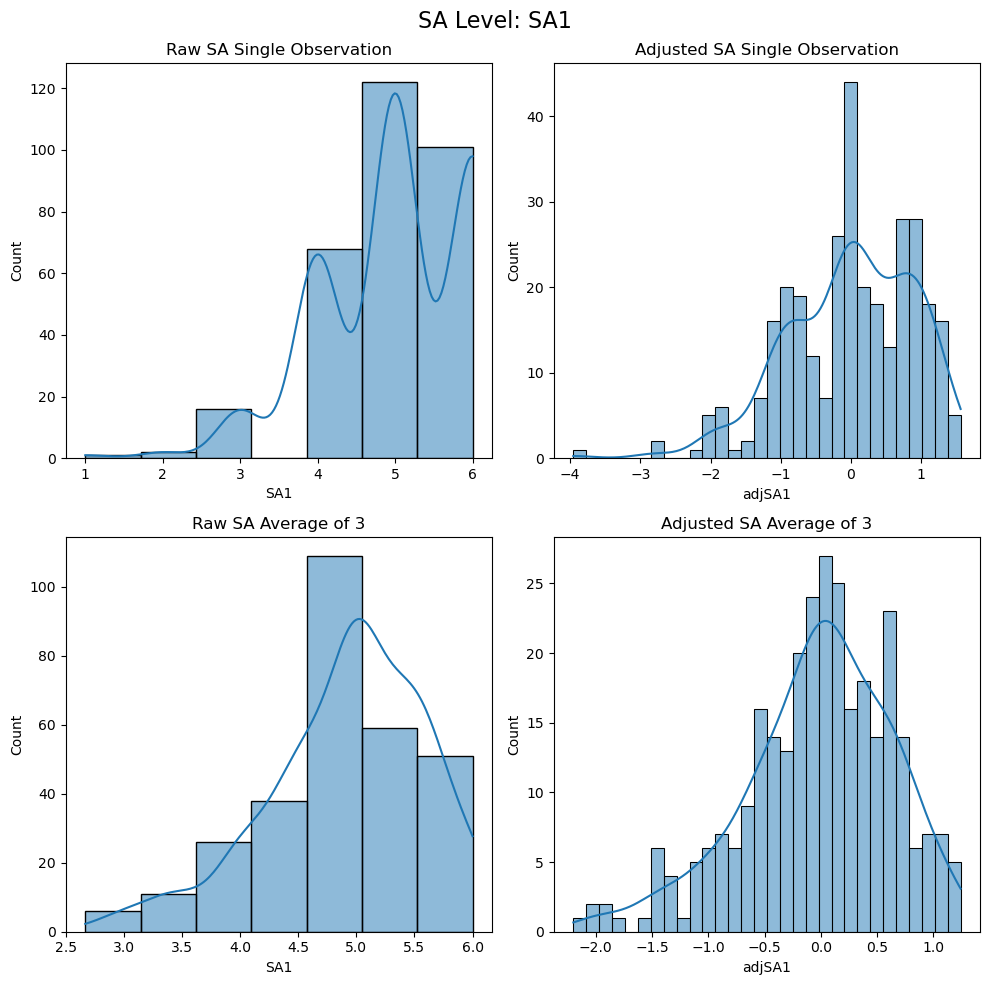

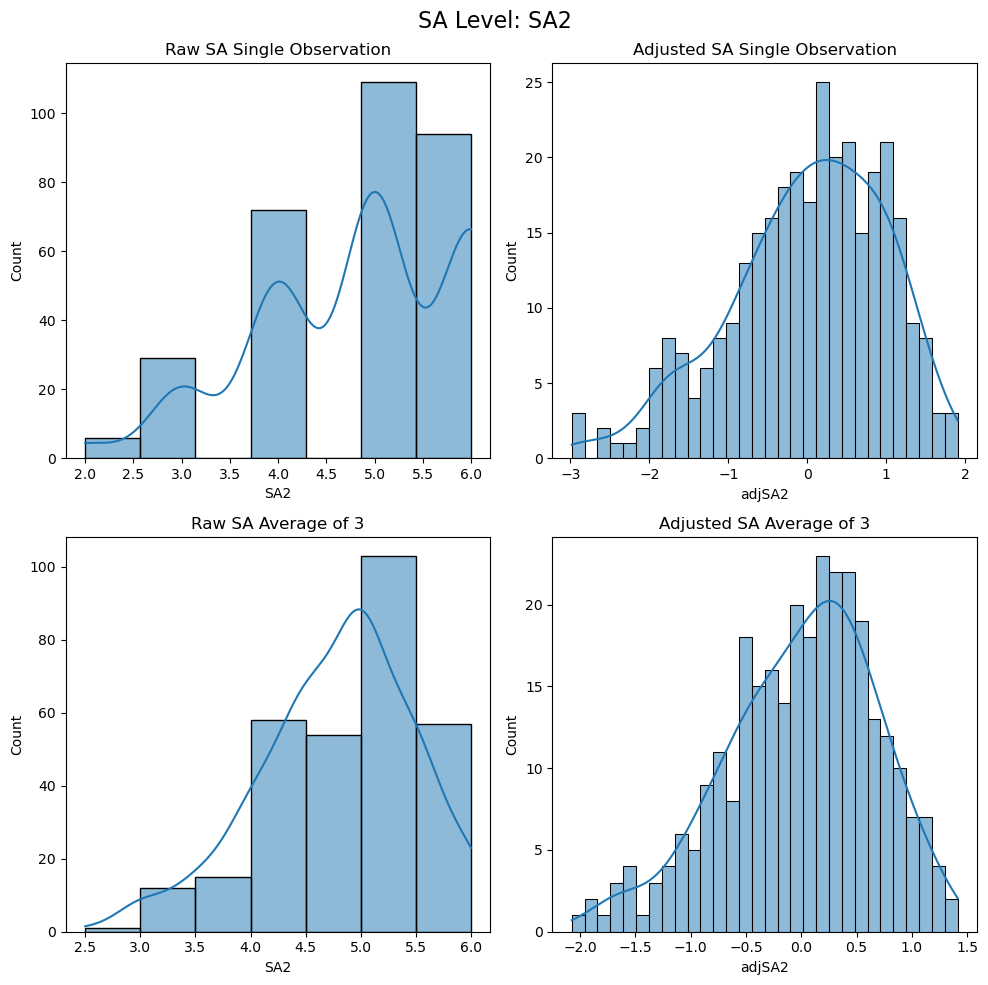

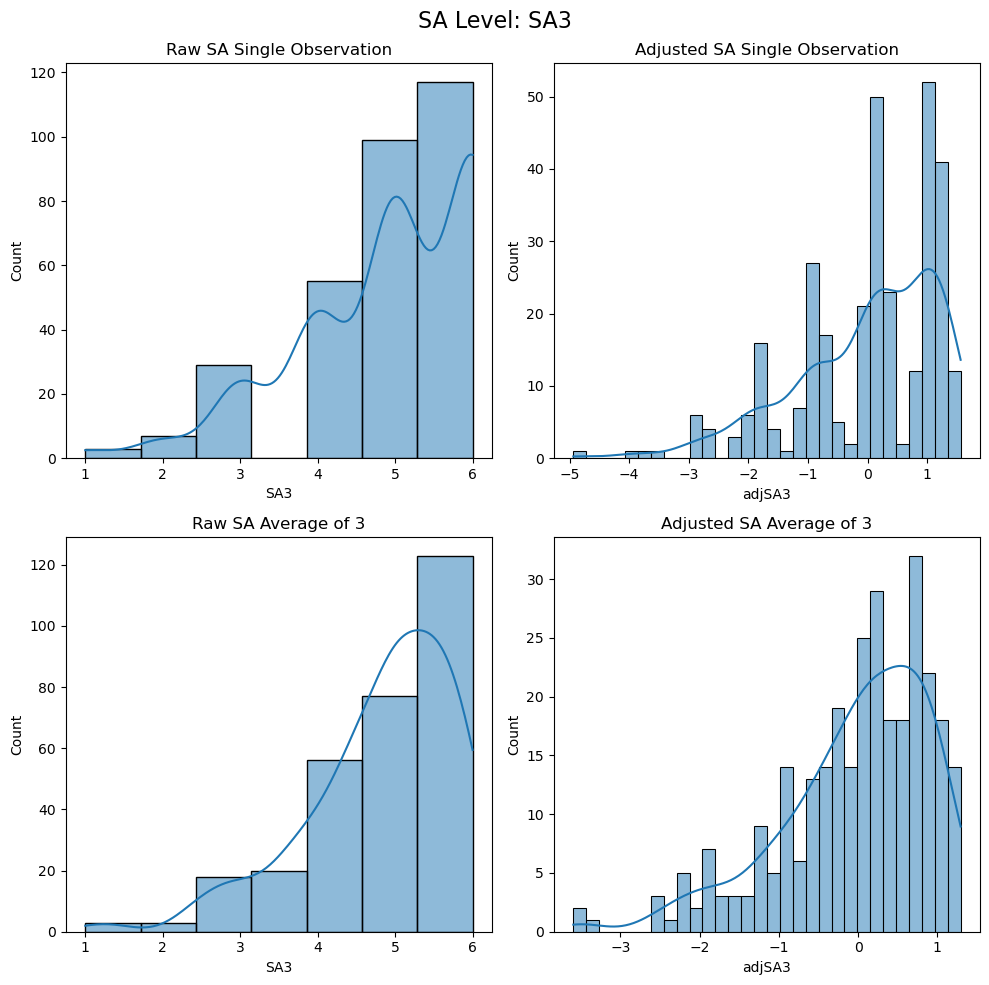

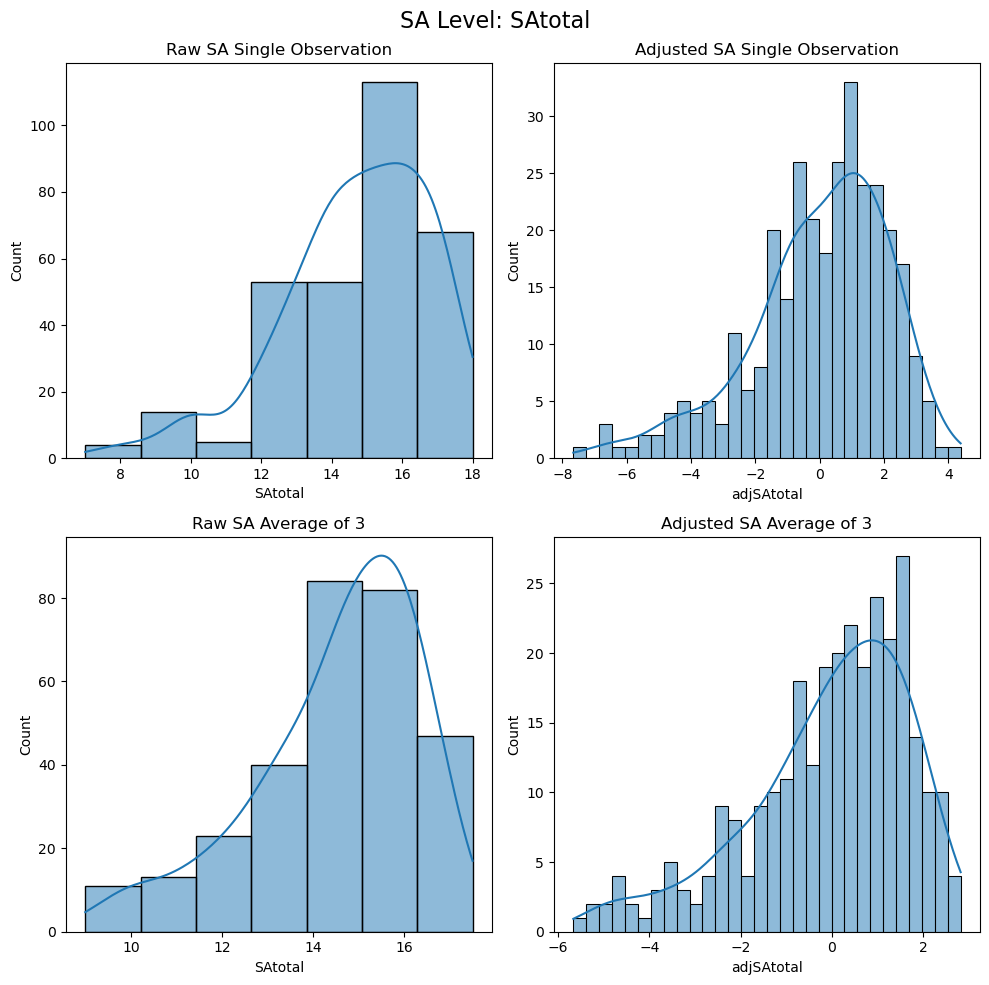

In [3]:
for level in ["SA1", "SA2", "SA3", "SAtotal"]:
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (10, 10))

    sns.histplot(raw_SA_SO_df[level], bins = 7, ax = ax1[0], kde = True)
    ax1[0].set_title(f"Raw SA Single Observation")

    sns.histplot(adj_SA_SO_df["adj" + level], bins = 30, ax = ax1[1], kde = True)
    ax1[1].set_title(f"Adjusted SA Single Observation")

    sns.histplot(raw_SA_avg_df[level], bins = 7, ax = ax2[0], kde = True)
    ax2[0].set_title(f"Raw SA Average of 3")

    sns.histplot(adj_SA_avg_df["adj" + level], bins = 30, ax = ax2[1], kde = True)
    ax2[1].set_title(f"Adjusted SA Average of 3")

    fig.suptitle(f"SA Level: {level}", fontsize = 16)

    plt.tight_layout()
    plt.show()

# Results: 
# Was looking for changes in distribution of SA scores as well as bimodal distributions
# Raw SA was closest to a bimodal distribution
# Adjusted SA makes it look more smooth and unimodal
# 

# Correlations Between Scores

In [4]:
SA1_df = pd.DataFrame({
    "raw_SA_SO": raw_SA_SO_df["SA1"],
    "adj_SA_SO": adj_SA_SO_df["adjSA1"],
    "raw_SA_avg": raw_SA_avg_df["SA1"],
    "adj_SA_avg": adj_SA_avg_df["adjSA1"]
})

SA2_df = pd.DataFrame({
    "raw_SA_SO": raw_SA_SO_df["SA2"],
    "adj_SA_SO": adj_SA_SO_df["adjSA2"],
    "raw_SA_avg": raw_SA_avg_df["SA2"],
    "adj_SA_avg": adj_SA_avg_df["adjSA2"]
})

SA3_df = pd.DataFrame({
    "raw_SA_SO": raw_SA_SO_df["SA3"],
    "adj_SA_SO": adj_SA_SO_df["adjSA3"],
    "raw_SA_avg": raw_SA_avg_df["SA3"],
    "adj_SA_avg": adj_SA_avg_df["adjSA3"]
})

TotalSA_df = pd.DataFrame({
    "raw_SA_SO": raw_SA_SO_df["SAtotal"],
    "adj_SA_SO": adj_SA_SO_df["adjSAtotal"],
    "raw_SA_avg": raw_SA_avg_df["SAtotal"],
    "adj_SA_avg": adj_SA_avg_df["adjSAtotal"]
})

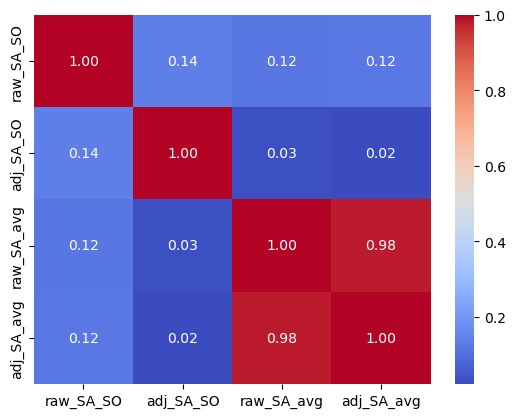

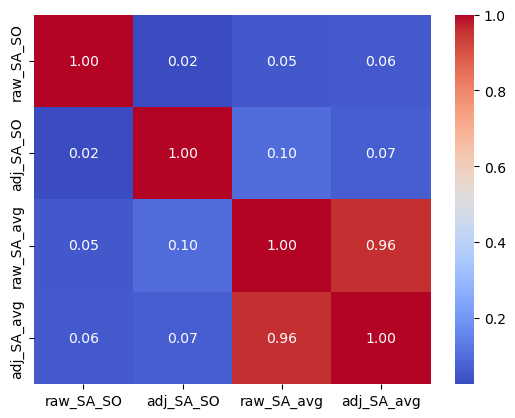

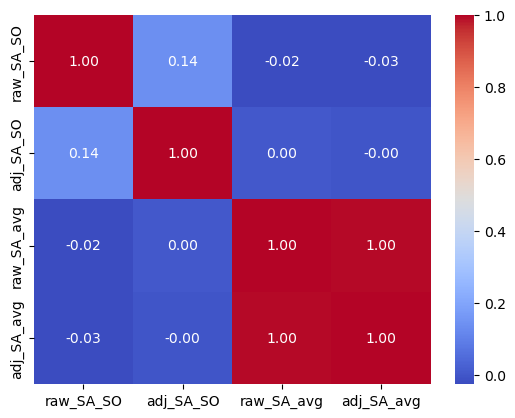

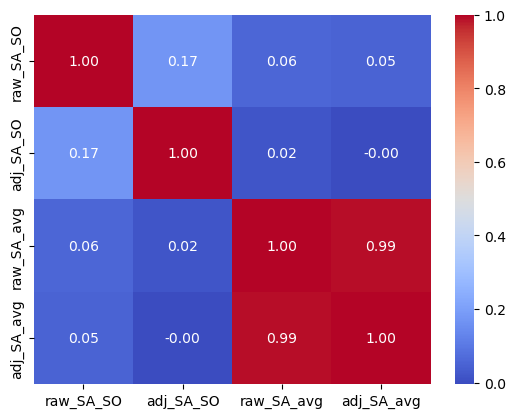

In [5]:
for df in [SA1_df, SA2_df, SA3_df, TotalSA_df]:
    sns.heatmap(df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
    plt.show()

# Results:
# No strong correlation between raw and adjusted SA scores for single observations
# Average of 3 shows a very strong correlation between each other
# No strong correlation between single observation and average of 3 for raw or adjusted SA scores

# Performance on Logistic Regression with L1 Regularization

## Median Splits With Accuracy Metric (One Group is Validation Set)

In [6]:
scores = {
    "model": ["Raw SA Single Observation", "Adjusted SA Single Observation",
             "Raw SA Average of 3", "Adjusted SA Average of 3"],
}

for level in ["SA1", "SA2", "SA3", "SAtotal"]:
    # Setup data structures to hold scores
    raw_SA_SO_scores = []
    adj_SA_SO_scores = []
    raw_SA_avg_scores = []
    adj_SA_avg_scores = []

    # Input datasets
    X_raw_SO = raw_SA_SO_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_SO = adj_SA_SO_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values
    X_raw_avg = raw_SA_avg_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_avg = adj_SA_avg_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values

    # Output datasets
    y_raw_SO = (raw_SA_SO_df[level] < np.median(raw_SA_SO_df[level])).values
    y_adj_SO = (adj_SA_SO_df["adj" + level] < np.median(adj_SA_SO_df["adj" + level])).values
    y_raw_avg = (raw_SA_avg_df[level] < np.median(raw_SA_avg_df[level])).values
    y_adj_avg = (adj_SA_avg_df["adj" + level] < np.median(adj_SA_avg_df["adj" + level])).values

    for _ in range(10):
        # Cross validation setup
        gkf = GroupKFold(n_splits = 30, shuffle = True)
        pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy = "mean")),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(penalty = "l1", max_iter = 10000, solver = "liblinear", random_state = 42))
        ])

        # Accumulate metric scores
        raw_SA_SO_scores.extend(cross_val_score(pipeline, X_raw_SO, y_raw_SO, cv = gkf, groups = raw_SA_SO_df["ID"], scoring = "accuracy", n_jobs = -1))
        adj_SA_SO_scores.extend(cross_val_score(pipeline, X_adj_SO, y_adj_SO, cv = gkf, groups = adj_SA_SO_df["ID"], scoring = "accuracy", n_jobs = -1))
        raw_SA_avg_scores.extend(cross_val_score(pipeline, X_raw_avg, y_raw_avg, cv = gkf, groups = raw_SA_avg_df["ID"], scoring = "accuracy", n_jobs = -1))
        adj_SA_avg_scores.extend(cross_val_score(pipeline, X_adj_avg, y_adj_avg, cv = gkf, groups = adj_SA_avg_df["ID"], scoring = "accuracy", n_jobs = -1))

    # Summarize scores for the SA level
    scores[level + " Average Score"] = np.round([np.mean(raw_SA_SO_scores), np.mean(adj_SA_SO_scores), np.mean(raw_SA_avg_scores), np.mean(adj_SA_avg_scores)], 3)
    scores[level + " STD Score"] = np.round([np.std(raw_SA_SO_scores), np.std(adj_SA_SO_scores), np.std(raw_SA_avg_scores), np.std(adj_SA_avg_scores)], 3)

display(pd.DataFrame(scores).set_index("model"))

,SA1 Average Score,SA1 STD Score,SA2 Average Score,SA2 STD Score,SA3 Average Score,SA3 STD Score,SAtotal Average Score,SAtotal STD Score
model,,,,,,,,
Raw SA Single Observation,0.672,0.179,0.547,0.125,0.599,0.199,0.541,0.199
Adjusted SA Single Observation,0.515,0.207,0.507,0.127,0.489,0.142,0.507,0.181
Raw SA Average of 3,0.520,0.225,0.524,0.171,0.568,0.184,0.520,0.240
Adjusted SA Average of 3,0.451,0.183,0.511,0.170,0.495,0.206,0.537,0.241


## Information Theory Splits (for Raw SA) (Accuracy Metric) (One Group is Validation Set)

In [7]:
scores = {
    "model": ["Raw SA Single Observation", "Adjusted SA Single Observation",
             "Raw SA Average of 3", "Adjusted SA Average of 3"],
}

for level in ["SA1", "SA2", "SA3", "SAtotal"]:
    # Setup data structures to hold scores
    raw_SA_SO_scores = []
    adj_SA_SO_scores = []
    raw_SA_avg_scores = []
    adj_SA_avg_scores = []

    # Input datasets
    X_raw_SO = raw_SA_SO_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_SO = adj_SA_SO_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values
    X_raw_avg = raw_SA_avg_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_avg = adj_SA_avg_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values

    # Output datasets
    y_raw_SO = (raw_SA_SO_df[level] < (5.0 if level != "SAtotal" else 15.0)).values
    y_adj_SO = (adj_SA_SO_df["adj" + level] < np.median(adj_SA_SO_df["adj" + level])).values
    y_raw_avg = (raw_SA_avg_df[level] < (5.0 if level != "SAtotal" else 15.0)).values
    y_adj_avg = (adj_SA_avg_df["adj" + level] < np.median(adj_SA_SO_df["adj" + level])).values

    for _ in range(10):
        # Cross validation setup
        gkf = GroupKFold(n_splits = 30, shuffle = True)
        pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy = "mean")),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(penalty = "l1", max_iter = 10000, solver = "liblinear", random_state = 42))
        ])

        # Accumulate metric scores
        raw_SA_SO_scores.extend(cross_val_score(pipeline, X_raw_SO, y_raw_SO, cv = gkf, groups = raw_SA_SO_df["ID"], scoring = "accuracy", n_jobs = -1))
        adj_SA_SO_scores.extend(cross_val_score(pipeline, X_adj_SO, y_adj_SO, cv = gkf, groups = adj_SA_SO_df["ID"], scoring = "accuracy", n_jobs = -1))
        raw_SA_avg_scores.extend(cross_val_score(pipeline, X_raw_avg, y_raw_avg, cv = gkf, groups = raw_SA_avg_df["ID"], scoring = "accuracy", n_jobs = -1))
        adj_SA_avg_scores.extend(cross_val_score(pipeline, X_adj_avg, y_adj_avg, cv = gkf, groups = adj_SA_avg_df["ID"], scoring = "accuracy", n_jobs = -1))

    # Summarize scores for the SA level
    scores[level + " Average Score"] = np.round([np.mean(raw_SA_SO_scores), np.mean(adj_SA_SO_scores), np.mean(raw_SA_avg_scores), np.mean(adj_SA_avg_scores)], 3)
    scores[level + " STD Score"] = np.round([np.std(raw_SA_SO_scores), np.std(adj_SA_SO_scores), np.std(raw_SA_avg_scores), np.std(adj_SA_avg_scores)], 3)

display(pd.DataFrame(scores).set_index("model"))

,SA1 Average Score,SA1 STD Score,SA2 Average Score,SA2 STD Score,SA3 Average Score,SA3 STD Score,SAtotal Average Score,SAtotal STD Score
model,,,,,,,,
Raw SA Single Observation,0.672,0.179,0.547,0.125,0.599,0.199,0.541,0.199
Adjusted SA Single Observation,0.514,0.210,0.509,0.128,0.493,0.142,0.502,0.181
Raw SA Average of 3,0.522,0.229,0.525,0.171,0.568,0.182,0.517,0.238
Adjusted SA Average of 3,0.454,0.181,0.498,0.186,0.460,0.213,0.523,0.235


## Median Splits with 8-Fold with 100 Repetitions (ROC-AUC Metric)

In [17]:
scores = {
    "model": ["Raw SA Single Observation", "Adjusted SA Single Observation",
             "Raw SA Average of 3", "Adjusted SA Average of 3"],
}

for level in ["SA1", "SA2", "SA3", "SAtotal"]:
    # Setup data structures to hold scores
    raw_SA_SO_scores = []
    adj_SA_SO_scores = []
    raw_SA_avg_scores = []
    adj_SA_avg_scores = []

    # Input datasets
    X_raw_SO = raw_SA_SO_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_SO = adj_SA_SO_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values
    X_raw_avg = raw_SA_avg_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_avg = adj_SA_avg_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values

    # Output datasets
    y_raw_SO = (raw_SA_SO_df[level] < np.median(raw_SA_SO_df[level])).values
    y_adj_SO = (adj_SA_SO_df["adj" + level] < np.median(adj_SA_SO_df["adj" + level])).values
    y_raw_avg = (raw_SA_avg_df[level] < np.median(raw_SA_avg_df[level])).values
    y_adj_avg = (adj_SA_avg_df["adj" + level] < np.median(adj_SA_avg_df["adj" + level])).values

    for _ in range(100):
        # Cross validation setup
        gkf = GroupKFold(n_splits = 5, shuffle = True)
        pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy = "mean")),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(penalty = "l1", max_iter = 10000, solver = "liblinear", random_state = 42))
        ])

        # Accumulate metric scores
        raw_SA_SO_scores.extend(cross_val_score(pipeline, X_raw_SO, y_raw_SO, cv = gkf, groups = raw_SA_SO_df["ID"], scoring = "roc_auc", n_jobs = -1))
        adj_SA_SO_scores.extend(cross_val_score(pipeline, X_adj_SO, y_adj_SO, cv = gkf, groups = adj_SA_SO_df["ID"], scoring = "roc_auc", n_jobs = -1))
        raw_SA_avg_scores.extend(cross_val_score(pipeline, X_raw_avg, y_raw_avg, cv = gkf, groups = raw_SA_avg_df["ID"], scoring = "roc_auc", n_jobs = -1))
        adj_SA_avg_scores.extend(cross_val_score(pipeline, X_adj_avg, y_adj_avg, cv = gkf, groups = adj_SA_avg_df["ID"], scoring = "roc_auc", n_jobs = -1))

    # Summarize scores for the SA level
    scores[level + " Average Score"] = np.round([np.mean(raw_SA_SO_scores), np.mean(adj_SA_SO_scores), np.mean(raw_SA_avg_scores), np.mean(adj_SA_avg_scores)], 3)
    scores[level + " STD Score"] = np.round([np.std(raw_SA_SO_scores), np.std(adj_SA_SO_scores), np.std(raw_SA_avg_scores), np.std(adj_SA_avg_scores)], 3)

display(pd.DataFrame(scores).set_index("model"))

,SA1 Average Score,SA1 STD Score,SA2 Average Score,SA2 STD Score,SA3 Average Score,SA3 STD Score,SAtotal Average Score,SAtotal STD Score
model,,,,,,,,
Raw SA Single Observation,0.538,0.088,0.531,0.063,0.479,0.096,0.529,0.094
Adjusted SA Single Observation,0.525,0.077,0.548,0.059,0.480,0.075,0.527,0.099
Raw SA Average of 3,0.502,0.104,0.536,0.084,0.538,0.104,0.520,0.118
Adjusted SA Average of 3,0.486,0.082,0.517,0.079,0.524,0.105,0.524,0.108


## Median Splits with 5-Fold with 20 Repetitions (F1 Metric)

In [11]:
scores = {
    "model": ["Raw SA Single Observation", "Adjusted SA Single Observation",
             "Raw SA Average of 3", "Adjusted SA Average of 3"],
}

for level in ["SA1", "SA2", "SA3", "SAtotal"]:
    # Setup data structures to hold scores
    raw_SA_SO_scores = []
    adj_SA_SO_scores = []
    raw_SA_avg_scores = []
    adj_SA_avg_scores = []

    # Input datasets
    X_raw_SO = raw_SA_SO_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_SO = adj_SA_SO_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values
    X_raw_avg = raw_SA_avg_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_avg = adj_SA_avg_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values

    # Output datasets
    y_raw_SO = (raw_SA_SO_df[level] < np.median(raw_SA_SO_df[level])).values
    y_adj_SO = (adj_SA_SO_df["adj" + level] < np.median(adj_SA_SO_df["adj" + level])).values
    y_raw_avg = (raw_SA_avg_df[level] < np.median(raw_SA_avg_df[level])).values
    y_adj_avg = (adj_SA_avg_df["adj" + level] < np.median(adj_SA_avg_df["adj" + level])).values

    for _ in range(20):
        # Cross validation setup
        gkf = GroupKFold(n_splits = 5, shuffle = True)
        pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy = "mean")),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(penalty = "l1", max_iter = 10000, solver = "liblinear", random_state = 42))
        ])

        # Accumulate metric scores
        raw_SA_SO_scores.extend(cross_val_score(pipeline, X_raw_SO, y_raw_SO, cv = gkf, groups = raw_SA_SO_df["ID"], scoring = "f1", n_jobs = -1))
        adj_SA_SO_scores.extend(cross_val_score(pipeline, X_adj_SO, y_adj_SO, cv = gkf, groups = adj_SA_SO_df["ID"], scoring = "f1", n_jobs = -1))
        raw_SA_avg_scores.extend(cross_val_score(pipeline, X_raw_avg, y_raw_avg, cv = gkf, groups = raw_SA_avg_df["ID"], scoring = "f1", n_jobs = -1))
        adj_SA_avg_scores.extend(cross_val_score(pipeline, X_adj_avg, y_adj_avg, cv = gkf, groups = adj_SA_avg_df["ID"], scoring = "f1", n_jobs = -1))

    # Summarize scores for the SA level
    scores[level + " Average Score"] = np.round([np.mean(raw_SA_SO_scores), np.mean(adj_SA_SO_scores), np.mean(raw_SA_avg_scores), np.mean(adj_SA_avg_scores)], 3)
    scores[level + " STD Score"] = np.round([np.std(raw_SA_SO_scores), np.std(adj_SA_SO_scores), np.std(raw_SA_avg_scores), np.std(adj_SA_avg_scores)], 3)

display(pd.DataFrame(scores).set_index("model"))

,SA1 Average Score,SA1 STD Score,SA2 Average Score,SA2 STD Score,SA3 Average Score,SA3 STD Score,SAtotal Average Score,SAtotal STD Score
model,,,,,,,,
Raw SA Single Observation,0.273,0.132,0.348,0.083,0.281,0.145,0.411,0.113
Adjusted SA Single Observation,0.501,0.092,0.509,0.085,0.468,0.095,0.489,0.113
Raw SA Average of 3,0.346,0.125,0.489,0.091,0.387,0.129,0.460,0.139
Adjusted SA Average of 3,0.431,0.120,0.501,0.100,0.482,0.107,0.476,0.108


## Median Splits with 5-Fold with 20 Repetitions (Accuracy Metric)

In [12]:
scores = {
    "model": ["Raw SA Single Observation", "Adjusted SA Single Observation",
             "Raw SA Average of 3", "Adjusted SA Average of 3"],
}

for level in ["SA1", "SA2", "SA3", "SAtotal"]:
    # Setup data structures to hold scores
    raw_SA_SO_scores = []
    adj_SA_SO_scores = []
    raw_SA_avg_scores = []
    adj_SA_avg_scores = []

    # Input datasets
    X_raw_SO = raw_SA_SO_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_SO = adj_SA_SO_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values
    X_raw_avg = raw_SA_avg_df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]).values
    X_adj_avg = adj_SA_avg_df.drop(columns = ["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]).values

    # Output datasets
    y_raw_SO = (raw_SA_SO_df[level] < np.median(raw_SA_SO_df[level])).values
    y_adj_SO = (adj_SA_SO_df["adj" + level] < np.median(adj_SA_SO_df["adj" + level])).values
    y_raw_avg = (raw_SA_avg_df[level] < np.median(raw_SA_avg_df[level])).values
    y_adj_avg = (adj_SA_avg_df["adj" + level] < np.median(adj_SA_avg_df["adj" + level])).values

    for _ in range(20):
        # Cross validation setup
        gkf = GroupKFold(n_splits = 5, shuffle = True)
        pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy = "mean")),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(penalty = "l1", max_iter = 10000, solver = "liblinear", random_state = 42))
        ])

        # Accumulate metric scores
        raw_SA_SO_scores.extend(cross_val_score(pipeline, X_raw_SO, y_raw_SO, cv = gkf, groups = raw_SA_SO_df["ID"], scoring = "accuracy", n_jobs = -1))
        adj_SA_SO_scores.extend(cross_val_score(pipeline, X_adj_SO, y_adj_SO, cv = gkf, groups = adj_SA_SO_df["ID"], scoring = "accuracy", n_jobs = -1))
        raw_SA_avg_scores.extend(cross_val_score(pipeline, X_raw_avg, y_raw_avg, cv = gkf, groups = raw_SA_avg_df["ID"], scoring = "accuracy", n_jobs = -1))
        adj_SA_avg_scores.extend(cross_val_score(pipeline, X_adj_avg, y_adj_avg, cv = gkf, groups = adj_SA_avg_df["ID"], scoring = "accuracy", n_jobs = -1))

    # Summarize scores for the SA level
    scores[level + " Average Score"] = np.round([np.mean(raw_SA_SO_scores), np.mean(adj_SA_SO_scores), np.mean(raw_SA_avg_scores), np.mean(adj_SA_avg_scores)], 3)
    scores[level + " STD Score"] = np.round([np.std(raw_SA_SO_scores), np.std(adj_SA_SO_scores), np.std(raw_SA_avg_scores), np.std(adj_SA_avg_scores)], 3)

display(pd.DataFrame(scores).set_index("model"))

,SA1 Average Score,SA1 STD Score,SA2 Average Score,SA2 STD Score,SA3 Average Score,SA3 STD Score,SAtotal Average Score,SAtotal STD Score
model,,,,,,,,
Raw SA Single Observation,0.658,0.062,0.573,0.059,0.597,0.073,0.541,0.068
Adjusted SA Single Observation,0.509,0.062,0.543,0.058,0.480,0.067,0.517,0.081
Raw SA Average of 3,0.556,0.075,0.530,0.072,0.550,0.068,0.506,0.091
Adjusted SA Average of 3,0.489,0.059,0.518,0.068,0.517,0.080,0.528,0.088
